# The Missing Data Gap

In data-driven prognostics, missing data is often cleaned before training. This leaves the question of what to do when we apply these models in the real world and observe msising data. In this notebook, we demonstrate the "gap" in performance when data is missing in a state-of-the-art model trained on only clean data (the first sub-dataset in the N-CMAPSS dataset).

In [2]:
import torch
import torch.nn as nn
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import DataUtils
import Masking

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading

In [4]:
batch_size = 64
trainloader, testloader = DataUtils.get_ncmapss_dataloaders(1, n_timesteps=10, batch=batch_size, workers=8, subsampled=True)

In [5]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
columns_kept = [False, False, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, False]
print(columns_kept)

[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]


## Defining an RUL Transformer Model

In [6]:
class RULTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prediction_window = 1 # only estimates the next point
        self.input_len = 10 # timesteps of 10
        self.n_cols = 46 # 46 columns present in the data
        self.embed_dim = 64 # project to a 64-dimensional space
        
        self.input_projection = nn.Linear(self.input_len*self.n_cols, self.embed_dim) 
        self.positional_embed = nn.Parameter(torch.randn(self.embed_dim)) # learned positional embeddings
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=4, activation="gelu", dim_feedforward=64)
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.rul_head = nn.Sequential(nn.Linear(self.embed_dim, self.prediction_window)) # linear rul prediction head 
    
    def forward(self, x):
        x = x.flatten(1)
        z = self.input_projection(x)
        z = z + self.positional_embed
        z = self.transformer_blocks(z)
        z = self.rul_head(z)
        
        return z.squeeze(1)

## Training on Clean Data

In [7]:
objective = nn.MSELoss()

rul_tran = RULTransformer().to(device)

lr = 1e-4
n_epochs = 5
optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        X = X.to(device)
        y = y.to(device)
        optim.zero_grad()
        yhat = rul_tran(X.float())
        loss = objective(yhat, y.float().squeeze(1))
        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:00<00:00, 127.73it/s]


Epoch: 1 Loss: 3270.5261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:03<00:00, 121.65it/s]


Epoch: 2 Loss: 9.78397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:03<00:00, 120.48it/s]


Epoch: 3 Loss: 0.6020137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:03<00:00, 119.92it/s]


Epoch: 4 Loss: 0.32051176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:03<00:00, 119.91it/s]

Epoch: 5 Loss: 0.33643198


In [13]:
test_mses = []
yhats = []
ys = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
        yhat = rul_tran(X.float().to(device))
        yhats.append(yhat.cpu())
        ys.append(y.cpu())
        test_mse = objective(yhat, y.float().to(device))
        test_mses.append(test_mse.item())
print("Test MSE:", np.mean(test_mses))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4274/4274 [00:35<00:00, 120.34it/s]

Test MSE: 25.635571355288644


In [14]:
print("Test RMSE: {}".format(np.sqrt(np.mean(test_mses))))

Test RMSE: 5.063158239210843


With clean test data, a model without tuned hyperparameters can achieve the above RMSE

## Injecting Missing Data

In [15]:
test_mses_missing = []
yhats_missing = []
ys_missing = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
        masked_X = Masking.mask_input(X)
        yhat = rul_tran(masked_X.float().to(device))
        yhats_missing.append(yhat.cpu())
        ys_missing.append(y.cpu())
        test_mse = objective(yhat, y.float().to(device))
        test_mses_missing.append(test_mse.item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4274/4274 [00:35<00:00, 121.29it/s]


In [16]:
print("Test MSE:", np.mean(test_mses_missing))
print("Test RMSE: {}".format(np.sqrt(np.mean(test_mses_missing))))

Test MSE: 775.0257772303765
Test RMSE: 27.839284783025164


The performance on missing data is much worse! There is a huge gap that needs to be addressed.

## Plotting the Gap

In [19]:
# Function to find the indices to split the plots
def find_splits(y_data):
    splits = [0]
    for i in range(1, len(y_data)):
        if y_data[i-1] == 0 and y_data[i] != 0:
            splits.append(i)
            
    splits.append(len(y_data))
    return splits

yhats = torch.cat(yhats)
yhats_missing = torch.cat(yhats_missing)
ys = torch.cat(ys)
split_idx = find_splits(ys)

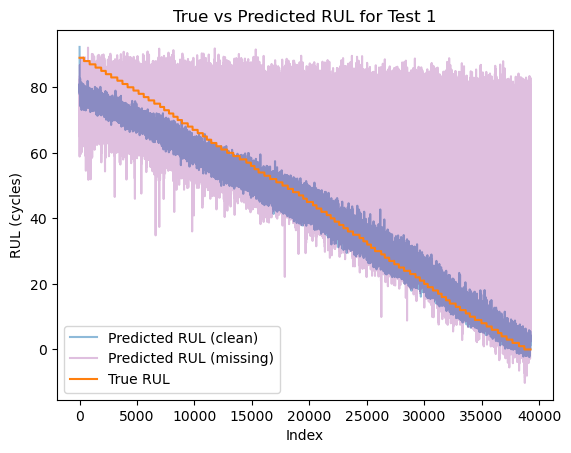

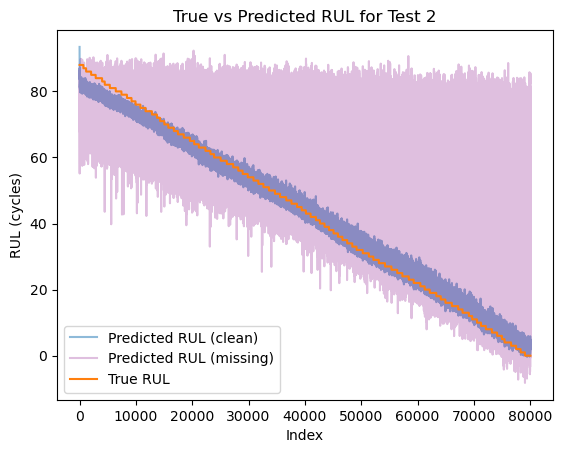

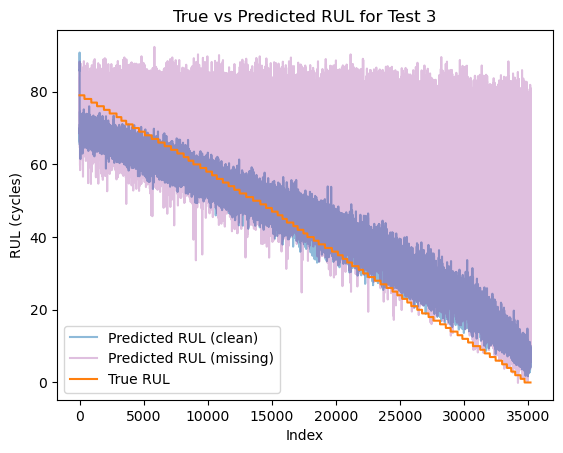

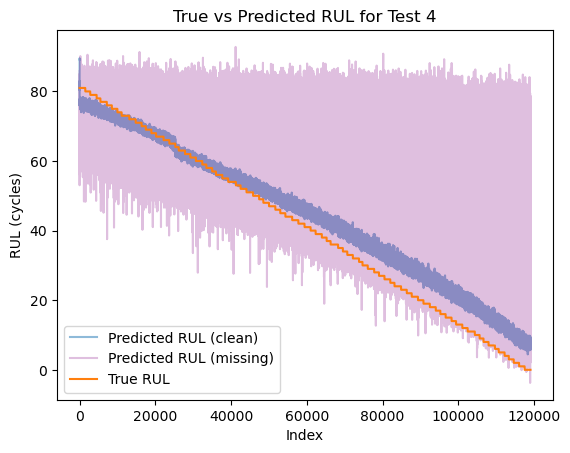

In [35]:
for i in range(len(split_idx)-1):
    num_pts = len(ys[split_idx[i]:split_idx[i+1]])
    plt.title("True vs Predicted RUL for Test " + str(i+1))
    plt.plot(range(num_pts), yhats[split_idx[i]:split_idx[i+1]], alpha=0.5, label='Predicted RUL (clean)')
    plt.plot(range(num_pts), yhats_missing[split_idx[i]:split_idx[i+1]], alpha=0.25, label='Predicted RUL (missing)', color='purple' )
    plt.plot(ys[split_idx[i]:split_idx[i+1]], label='True RUL')
    plt.xlabel("Index")
    plt.ylabel("RUL (cycles)")
    plt.legend()
    plt.show()